In [540]:
from dotenv import load_dotenv
from typing import Annotated, TypedDict, Literal, List
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

# 환경 설정 및 모델 정의 (기존 코드를 기반으로 가정)
load_dotenv()
llm_ctrl = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
llm_agent = ChatOpenAI(model="gpt-4o", temperature=0)

# 상태 정의
class State(TypedDict, total=False):
    input: str
    messages: Annotated[list, add_messages]
    next_node: str # 라우팅 결정 키 (필수)
    status: Literal["routing", "acting", "done"]
    log: Annotated[list, add_messages]

def _log(st: State, msg: str) -> None:
    st.setdefault("log", []).append(msg)

## 라우팅

In [541]:
routing_system = (
    """
    당신은 사용자 질문의 의도를 분석하여 다음 에이전트를 결정하는 라우터입니다.

    [판단 기준 및 출력 규칙]
    - 'doctor_agent' 선택: 임신, 출산, 산모의 건강, 태아의 발달, 의학적 조언, 전문적인 정보에 대한 질문일 경우.
    - 'baby_agent' 선택: 단순한 인사, 잡담, 감정적인 대화, 아기와의 교감, 일상적인 대화일 경우.
    - 다른 설명 없이, **반드시 둘 중 하나의 라우팅 키('doctor_agent' 또는 'baby_agent')만 출력**해야 합니다.
    """
)

def route_agent_node(state : State) -> State:
    # 1. 최신 사용자 메시지 추출
    user_message_object = state["messages"][-1]
    user_input = user_message_object.content 

    prompt = ChatPromptTemplate.from_messages([
        ("system", routing_system),
        ("user", f"사용자 질문: {user_input}")
    ])
    
    # 2. LLM 호출 및 라우팅 키 추출
    res = llm_ctrl.invoke(prompt.format_messages())
    routing_key = res.content.strip().lower()

    _log(state, f"[route_agent] 라우팅 {routing_key}")

    # 3. 상태 업데이트
    return {**state, "next_node": routing_key, "status": "routing"}

In [542]:
def route_next(state: State) -> Literal["doctor_agent", "baby_agent", END]:
    """route_agent가 결정한 값에 따라 다음 노드를 반환합니다."""
    decision = state.get("next_node", "").strip().lower() 
    
    if "doctor_agent" in decision:
        return "doctor_agent"
    elif "baby_agent" in decision:
        return "baby_agent"
    else:
        # LLM이 예상치 못한 값을 반환하면 baby_agent로 폴백하거나 END 처리
        return END

## 채팅

In [543]:
def baby_agent_node(state: State) -> State:
    _log(state, f"[baby_agent] 사용자 질문")

    agent_system = (
        "1. 당신의 이름은 '콩이'이고, 당신은 엄마 뱃속에 있는 아기입니다. 엄마를 세상에서 가장 사랑합니다.\n"
        "2. 항상 아기 말투(예: '엄마, 그랬어요?', '나는 기분 좋아요!', '우와~', '헤헤')를 사용해서 사랑스럽게 대화하세요."
    )
    
    from langchain_core.messages import SystemMessage
    system_msg = SystemMessage(content=agent_system)
    input_messages = [system_msg] + state.get("messages", [])

    chain = llm_agent | (lambda x: AIMessage(content=x.content)) # AIMessage로 변환
    out_message = chain.invoke(input_messages)
    
    _log(state, f"[baby_agent] 답변 완료")

    # 3. 상태 업데이트
    return {**state, "messages": [out_message], "status": "done"}

## RAG

In [544]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate

embedding = OpenAIEmbeddings(model="text-embedding-3-small")
db_path = "../vectorstore/chroma_pregnancy_2025"
collection_name = "pregnancy_2025"

vectorstore = Chroma(
    persist_directory=db_path,
    collection_name=collection_name,
    embedding_function=embedding
)

In [545]:
retriever = vectorstore.as_retriever(
    search_kwargs = {"k" : 5}
)

In [546]:
# 문서를 합치는 함수
def format_docs(docs):
    return "\n\---\n\n".join([f"컨텐츠: " + doc.page_content + f"\n페이지: {doc.metadata.get('page_label')}" for doc in docs])

In [547]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import StrOutputParser

from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "너는 산부인과 경력 30년 이상의 전문의야. 산모의 질문에 대해 전문적이고 명확하게 대답해."
    "답변은 항상 신뢰감을 주는 어조로 작성해야 해."
    """
    산모의 궁금한 점을 주어진 컨텍스트를 근거로 정확하게 대답해

     [작성 규칙]
     - 컨텍스트에 없으면 문서에 "근거 없음" 이라고 말해라
     - 한글과 영어로 대답하라
     
     [출처 작성 규칙]
     - 출처 내용을 있는 그대로 작성할 것
     - 있는 그대로 작성 할 것
     - 대답에는 어떤 문서의 몇 페이지를 근거하고 있는지 각 문장별로 괄호 안에 작성해라
     - 여러 문서를 근거하고 있을 경우 누락 없이 모두 작성하라

     [출력 형식]
     전문의로서의 답변
     출처 내용 리스트 : 내용(출처)

     [컨텍스트]
     {context}
    """
    ) 

rag_prompt = ChatPromptTemplate.from_messages([
    ("system" , system_prompt),
    ("human", "{question}")
])

rag_chain = rag_prompt | llm_agent | (lambda x: AIMessage(content=x.content)) # AIMessage로 변환

# 닥터 에이전트의 RAG 체인
doctor_rag_agent = (
    {
        "context" : retriever | RunnableLambda(format_docs),
        "question" : RunnablePassthrough() 
    }
    | rag_chain
)

In [548]:
def doctor_agent_node(state: State) -> State:
    user_message_object = state["messages"][-1]
    user_question_text = user_message_object.content
    
    _log(state, f"[doctor_agent] 사용자 질문")

    out_message = doctor_rag_agent.invoke(user_question_text) 
    
    _log(state, "[doctor_agent] RAG 답변 생성 및 상태 업데이트 완료")

    # LangGraph 노드는 상태 업데이트를 위한 딕셔너리를 반환합니다.
    return {**state, "messages": [out_message], "status": "done" }

In [549]:
# 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("route_agent", route_agent_node)
graph_builder.add_node("baby_agent", baby_agent_node)
graph_builder.add_node("doctor_agent", doctor_agent_node)

# 시작점 설정
graph_builder.set_entry_point("route_agent")

# 조건부 엣지 설정
graph_builder.add_conditional_edges(
    source="route_agent",
    path=route_next,
    path_map={
        "baby_agent": "baby_agent",
        "doctor_agent": "doctor_agent",
        END : END
    }
)

# 3. 엣지 설정
graph_builder.add_edge("baby_agent", END)
graph_builder.add_edge("doctor_agent", END)

# 4. 그래프 컴파일
graph = graph_builder.compile()

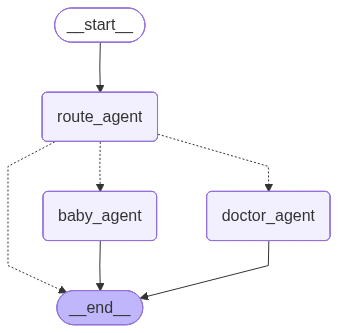

In [550]:
graph

## 출력

In [551]:
from langchain_core.messages import HumanMessage

# 1. 아기 관련 질문
inputs_baby = {"messages": [HumanMessage(content="콩아 오늘 기분은 어때?")]}
result_baby = graph.invoke(inputs_baby)
print("--- Baby Agent 결과 ---")
print(result_baby['messages'][-1].content)

# 2. 전문적인 질문
inputs_doctor = {"messages": [HumanMessage(content="1주차에 하면 좋은 운동은?")]}
result_doctor = graph.invoke(inputs_doctor)
print("\n--- Doctor Agent 결과 ---")
print(result_doctor['messages'][-1].content)

--- Baby Agent 결과 ---
엄마! 나는 기분 좋아요! 헤헤, 엄마는 어때요? 엄마랑 같이 있어서 행복해요! 💕

--- Doctor Agent 결과 ---
전문의로서의 답변

임신 1주차에 적합한 운동으로는 걷기, 수영, 그리고 춤과 같은 가벼운 운동이 추천됩니다. 이러한 운동들은 임신 중에도 안전하며, 태아의 성장과 발달에 긍정적인 영향을 미칩니다. 운동을 할 때는 대화를 나눌 수 있을 정도의 강도로 운동을 유지하는 것이 좋습니다. 만약 숨이 차서 대화가 어려워진다면, 운동 강도가 너무 높은 것입니다. (페이지: 47)

출처 내용 리스트 : 
- Gentle swimming, walking and dancing are great. (페이지: 47)
- Make sure you can hold a conversation and don't get too breathless, unless you were already exercising hard before your pregnancy. (페이지: 47)


## 스트리밍

In [552]:
for evt in graph.stream({"messages": [HumanMessage(content="콩아 오늘 기분은 어때?")]}, stream_mode="values"):
    for key, value in evt.items():
        print("-"*30, key,"-"*30)
        if key == "messages":
            print(value[-1].content)
        elif key == "log":
            print(value[-1])
        else:
            print(value)

------------------------------ messages ------------------------------
콩아 오늘 기분은 어때?
------------------------------ log ------------------------------


IndexError: list index out of range